# Combining keyword and semantic search for text and images using Amazon Bedrock and Amazon OpenSearch

This notebook is provided with the blog post [Combining keyword and semantic search for text and images using Amazon Bedrock and Amazon OpenSearch](https://aws.amazon.com/blogs/machine-learning/combine-keyword-and-semantic-search-for-text-and-images-using-amazon-bedrock-and-amazon-opensearch-service/).


## Prerequisites
* Noted the OpenSearch Domain endpoint.
* Created an IAM role to provide OpenSearch service access to Bedrock - Noted the role ARN. 

## Table of Contents
**[Setting up](#setting-up)**
* [Install dependencies ](#Install-dependencies)

* [Import required libraries](#Import-required-libraries)

* [Define constants and service endpoints that will be used throughout the notebook](#Define-constants-and-service-endpoints-that-will-be-used-throughout-the-notebook)

**[Connecting Amazon Bedrock hosted models](#Connecting-Amazon-Bedrock-hosted-models)**

* [Step 1 - Create Model group](#Step-1---Create-Model-group)

* [Step 2 - Create Amazon Titan Multimodal Embeddings model connector](#Step-2---Create-Amazon-Titan-Multimodal-Embeddings-model-connector)

* [Step 3 - Register model to model group and deploy model](#Step-3---Register-model-to-model-group-and-deploy-model)

**[Create Amazon OpenSearch Search Pipeline](#Create-Amazon-OpenSearch-Search-Pipeline)**


**[Data Ingestion Workflow](#Data-Ingestion-Workflow)**
* [Step 1 - Use OpenSearch client to create an OpenSearch index](#Step-1---Use-OpenSearch-client-to-create-an-OpenSearch-index)

* [Step 2 - Prepare `listings` dataset for Amazon OpenSearch ingestion](#Step-2---Prepare-listings-dataset-for-Amazon-OpenSearch-ingestion)

* [Step 3 - Ingest the prepared `listings` data into Amazon OpenSearch](#Step-3---Ingest-the-prepared-listings-data-into-Amazon-OpenSearch)

  * [Generate `batches_pipeline` for ingestion](#Generate-batches_pipeline-for-ingestion)

  * [Ingest data to Amazon OpenSearch](#Ingest-data-to-Amazon-OpenSearch)

* [Step 4 - Test data ingestion](#Step-4---Test-data-ingestion)

**[Query Workflow](#Query-Workflow)**
* [Step 1 - Create Amazon OpenSearch query functions](#Step-1---Create-Amazon-OpenSearch-query-functions)

* [Step 2 - Test Search Methods](#Step-2---Test-Search-Methods)

  * [Keyword Search](#Keyword-Search)
  
  * [Semantic Search using text and image as input](#Semantic-Search-using-text-and-image-as-input)

  * [Hybrid Search using only text as input](#Hybrid-Search-using-only-text-as-input)
  
  * [Hybrid Search using only image as input](#Hybrid-Search-using-only-image-as-input)
  
  * [Hybrid Search using text and image as input](#Hybrid-Search-using-text-and-image-as-input)
 
**[Cleanup](#Cleanup)**
 


## Setting up

### Install dependencies

In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Import required libraries

In [2]:
import boto3, botocore
from utility import *
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth
import requests
import pandas as pd
import s3fs

### Define constants and service endpoints that will be used throughout the notebook
If you are using the provided CloudFormation template, the following role ARN and endpoint inputs will be provided as an output of the CloudFormation stack. For addtional details for using the provided template see [Creating and managing stacks](https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/stacks.html). Otherwise, you can provide your own input for your custom role and existing OpenSearch Service endpoint.

In [3]:
OPENSEARCH_ENDPOINT = "https://<<YOUR OPENSEARCH_ENDPOINT>>"
BEDROCK_ROLE_ARN = "<<YOUR BEDROCK_ROLE_ARN>>"

In [4]:
AWS_REGION_NAME = "us-east-1"
OPENSEARCH_INDEX_NAME = "products-multimodal-index"
OPENSEARCH_SEARCH_PIPELINE_NAME = "hybrid-search-pipeline"
BEDROCK_MODEL_ID = "amazon.titan-embed-image-v1"
BEDROCK_ENDPOINT = f"https://bedrock-runtime.{AWS_REGION_NAME}.amazonaws.com/model/{BEDROCK_MODEL_ID}/invoke"
AMAZON_BERKELEY_OBJECTS_S3_BUCKET = 'amazon-berkeley-objects'#https://registry.opendata.aws/amazon-berkeley-objects/
OPENSEARCH_INGEST_BATCH_SIZE = 100
OPENSEARCH_KEYWORD_WEIGHT = 0.4

In [5]:
boto3.setup_default_session(region_name=AWS_REGION_NAME)
session = boto3.Session()
credentials = session.get_credentials()
open_search_auth = AWSV4SignerAuth(credentials, region=AWS_REGION_NAME, service="es")

In [6]:
amazon_berkeley_s3 = boto3.resource('s3', region_name='us-east-1', config=botocore.config.Config(signature_version=botocore.UNSIGNED))
amazon_berkeley_bucket = amazon_berkeley_s3.Bucket(AMAZON_BERKELEY_OBJECTS_S3_BUCKET)

In [7]:
bedrock_client = boto3.client('bedrock-runtime', region_name=AWS_REGION_NAME)

In [8]:
# Create opensearch client
opensearch_client = OpenSearch(
    hosts=[OPENSEARCH_ENDPOINT],
    http_auth=open_search_auth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    pool_maxsize=20,
)

## Connecting Amazon Bedrock hosted models
In this step we will connect the Amazon Titan Multimodal Embedding model on Amazon Bedrock with OpenSearch. 
For more information see [Bedrock connector blueprint example for Titan embedding model](https://github.com/opensearch-project/ml-commons/blob/2.x/docs/remote_inference_blueprints/bedrock_connector_titan_multimodal_embedding_blueprint.md).

### Step 1 - Create Model group

In [9]:
payload = {
    "name": "bedrock_multi_modal_group",
    "description": "Titan Multi modal embedding modal"
}
response = requests.post(
    url=f"{OPENSEARCH_ENDPOINT}/_plugins/_ml/model_groups/_register",
    json=payload,
    headers={"Content-Type": "application/json"},
    auth=open_search_auth
)
model_group_id = response.json()['model_group_id']

### Step 2 - Create Amazon Titan Multimodal Embeddings model connector
In this step, we need to provide our own pre- and post-processing functions for this specific model. Please refer to [Custom pre- and post-processing functions](https://opensearch.org/docs/latest/ml-commons-plugin/remote-models/blueprints/#custom-pre--and-post-processing-functions) and [Build Multimodal Search with Amazon OpenSearch service](https://github.com/aws-samples/AI-search-with-amazon-opensearch-service/blob/main/opensearch-multimodalsearch/multimodal_search_with_opensearch_service.ipynb) for details.

In [10]:
payload = {
  "name": "Amazon Bedrock Connector: multi-modal embedding",
  "description": "The connector to bedrock Titan multi-modal embedding model",
  "version": 1,
  "protocol": "aws_sigv4",
  "parameters": {
    "region": AWS_REGION_NAME,
    "service_name": "bedrock",
    "model": BEDROCK_MODEL_ID,
    "input_docs_processed_step_size": 2
  },
  "credential": {
    "roleArn": BEDROCK_ROLE_ARN
  },
  "actions": [
    {
      "action_type": "predict",
      "method": "POST",
      "url": BEDROCK_ENDPOINT,
      "headers": {
        "content-type": "application/json",
        "x-amz-content-sha256": "required"
      },
      "request_body": "{ \"inputText\": \"${parameters.inputText:-null}\", \"inputImage\": \"${parameters.inputImage:-null}\" }",
      "pre_process_function": "\n    StringBuilder parametersBuilder = new StringBuilder(\"{\");\n    if (params.text_docs.length > 0 && params.text_docs[0] != null) {\n      parametersBuilder.append(\"\\\"inputText\\\":\");\n      parametersBuilder.append(\"\\\"\");\n      parametersBuilder.append(params.text_docs[0]);\n      parametersBuilder.append(\"\\\"\");\n      \n      if (params.text_docs.length > 1 && params.text_docs[1] != null) {\n        parametersBuilder.append(\",\");\n      }\n    }\n    \n    \n    if (params.text_docs.length > 1 && params.text_docs[1] != null) {\n      parametersBuilder.append(\"\\\"inputImage\\\":\");\n      parametersBuilder.append(\"\\\"\");\n      parametersBuilder.append(params.text_docs[1]);\n      parametersBuilder.append(\"\\\"\");\n    }\n    parametersBuilder.append(\"}\");\n    \n    return  \"{\" +\"\\\"parameters\\\":\" + parametersBuilder + \"}\";",
      "post_process_function": "\n      def name = \"sentence_embedding\";\n      def dataType = \"FLOAT32\";\n      if (params.embedding == null || params.embedding.length == 0) {\n          return null;\n      }\n      def shape = [params.embedding.length];\n      def json = \"{\" +\n                 \"\\\"name\\\":\\\"\" + name + \"\\\",\" +\n                 \"\\\"data_type\\\":\\\"\" + dataType + \"\\\",\" +\n                 \"\\\"shape\\\":\" + shape + \",\" +\n                 \"\\\"data\\\":\" + params.embedding +\n                 \"}\";\n      return json;\n    "
    }
  ] 
}

response = requests.post(
    url=f"{OPENSEARCH_ENDPOINT}/_plugins/_ml/connectors/_create",
    json=payload,
    headers={"Content-Type": "application/json"},
    auth=open_search_auth
)
connector_id = response.json()['connector_id']

### Step 3 - Register model to model group and deploy model

In [11]:
payload={
  "name": "Bedrock multi-modal embedding model",
  "function_name": "remote",
  "model_group_id": model_group_id,
  "description": "Titan Multi modal embedding",
  "connector_id": connector_id
}
response = requests.post(
    url=f"{OPENSEARCH_ENDPOINT}/_plugins/_ml/models/_register?deploy=true",
    json=payload,
    headers={"Content-Type": "application/json"},
    auth=open_search_auth
)
model_id = response.json()['model_id']

## Create Amazon OpenSearch Search Pipeline

In [12]:
payload={
  "phase_results_processors": [
    {
      "normalization-processor": {
        "normalization": {
          "technique": "min_max"
        },
        "combination": {
          "technique": "arithmetic_mean",
          "parameters": {
            "weights": [
              OPENSEARCH_KEYWORD_WEIGHT,
              1 - OPENSEARCH_KEYWORD_WEIGHT
            ]
          }
        }
      }
    }
  ]
}
response = requests.put(
    url=f"{OPENSEARCH_ENDPOINT}/_search/pipeline/"+OPENSEARCH_SEARCH_PIPELINE_NAME,
    json=payload,
    headers={"Content-Type": "application/json"},
    auth=open_search_auth
)

# Data Ingestion Workflow
In this step, we extract text and images from the source bucket, encode images to Base64, and load text and encoded images to OpenSearch.

### Step 1 - Use OpenSearch client to create an OpenSearch index

In [13]:
response = opensearch_client.indices.create(
    index=OPENSEARCH_INDEX_NAME,
    body={
      "settings": {
        "index.knn": True,
        "number_of_shards": 2
      },
      "mappings": {
        "properties": {
          "vector_embedding": {
            "type": "knn_vector",
            "dimension": 1024,
            "method": {
              "name": "hnsw",
              "engine": "lucene",
              "parameters": {}
            }
          }
        }
      }
    }
)

### Step 2 - Prepare `listings` dataset for Amazon OpenSearch ingestion

[Amazon Berkeley Objects](https://registry.opendata.aws/amazon-berkeley-objects/) is a collection of 147,702 product listings with
multilingual metadata and 398,212 unique catalog images.

In this step, we load all product listings and filter 1,507 product listing where `domain_name` == 'amazon.com' and `product_type` == 'SHOES'. Then, we filter listings details to maintain only 'en_US' and relevant metadata.

In [14]:
listings = pd.read_json(f"s3://{AMAZON_BERKELEY_OBJECTS_S3_BUCKET}/listings/listings.json.gz", lines=True)
listings = listings[listings['domain_name'] == 'amazon.com']

In [15]:
multi_language_columns = ['brand','bullet_point','color','item_name','item_weight','material','model_name','item_keywords','style','pattern','item_shape','fabric_type','product_description','finish_type']
listings[multi_language_columns] = listings[multi_language_columns].map(filter_en_us)

single_value_columns = ['model_number','product_type','main_image_id','other_image_id','item_keywords','node','model_year']
listings[single_value_columns] = listings[single_value_columns].map(filter_single_value)

listings['item_weight'] = listings['item_weight'].map(filter_weight)
listings['item_dimensions'] = listings['item_dimensions'].map(filter_dimensions)
listings['node'] = listings['node'].map(filter_node_list)

In [16]:
listings = listings[listings['product_type'] == 'SHOES']

In the following step we add the S3 main image path to `listings`.

In [17]:
images = pd.read_csv(f"s3://{AMAZON_BERKELEY_OBJECTS_S3_BUCKET}/images/metadata/images.csv.gz")
listings = listings.merge(images[['image_id','path']], left_on="main_image_id", right_on="image_id")
listings.shape

(1507, 30)

Finally, we remove multiple listing that use the same images set. This exist for product with multiple size variations.

In [18]:
listings = listings.drop_duplicates(subset=['path'])
listings.shape

(649, 30)

### Step 3 - Ingest the prepared `listings` data into Amazon OpenSearch

#### Generate `batches_pipeline` for ingestion
In this step we filter only relevant features, fetch the images from S3, encode the image files into Base64, generate embeedings, and create a list of data batches.
Each data batch contains BATCH_SIZE documents. Each document contains the relevant features and the embeddings to be ingeted into OpenSearch.

In [19]:
feature_filter = ['bullet_point','color','item_name','material','fabric_type','item_keywords','style','path']
batches_pipeline = [] 
data_batch = []

for index, row in listings.iterrows():
    data_row = row[feature_filter][~row[feature_filter].isna()].to_dict()
    data_row['vector_embedding'] = generate_embedding(
        amazon_berkeley_bucket, row.item_name, row.path, bedrock_client, BEDROCK_MODEL_ID)
    opensearch_document = {
        "index": {
            "_index": OPENSEARCH_INDEX_NAME, 
            "_id": row.item_id
        }
    }
    data_batch.append(opensearch_document)
    data_batch.append(json.dumps(data_row))
    
    if len(data_batch) >= OPENSEARCH_INGEST_BATCH_SIZE:
        batches_pipeline.append(data_batch)
        data_batch = []

#### Ingest data to Amazon OpenSearch

In [20]:
for data_batch in batches_pipeline:
    response = opensearch_client.bulk(
        index=OPENSEARCH_INDEX_NAME,
        body=data_batch,
        refresh=True
    )
print(response['errors'])

False


### Step 4 - Test-data-ingestion

In [21]:
response = opensearch_client.search(
    index=OPENSEARCH_INDEX_NAME,
    body={
        "size": 1,
        "query": {
            "match_all": {}
        }
    }
)
print(json.dumps(response)[:1000])

{"took": 3, "timed_out": false, "_shards": {"total": 2, "successful": 2, "skipped": 0, "failed": 0}, "hits": {"total": {"value": 600, "relation": "eq"}, "max_score": 1.0, "hits": [{"_index": "products-multimodal-index", "_id": "B07N28GDSF", "_score": 1.0, "_source": {"color": "Blau (Blue Blue)", "item_name": "find. Suede Moccasins, Blau Blue), 9 UK", "item_keywords": "UK", "style": "Moccasin", "path": "66/6641bc25.jpg", "vector_embedding": [0.020712875, 0.02249569, 0.014160437, -0.005589884, 0.0044906843, 0.005173881, -0.0006590341, 0.0004970068, 0.014703786, -0.10505417, -0.007681257, 0.0163458, -0.0008693645, -0.062057406, 0.009973447, -0.00977788, -0.027260363, 0.0073709795, 0.009979823, -0.028372653, 0.024071712, 0.031965278, 0.05092434, -0.06041707, 0.048761144, 0.009385684, 0.048464224, -0.00902224, -0.0017881835, -0.017927036, 0.04218024, -0.008287886, 0.04619331, -0.0005591451, 0.025143828, -0.00069629773, 0.022167811, -0.015230009, -0.0057837036, 0.055370327, 0.0071569276, -0.

# Query Workflow

### Step 1 - Create Amazon OpenSearch query functions

#### Function to perform lexical search

In [22]:
def keyword_search(query_text):
    payload = {
        "query": {
            "multi_match": {            
                "query": query_text,
            }
        },
    }
    response = requests.get(
        url=f"{OPENSEARCH_ENDPOINT}/{OPENSEARCH_INDEX_NAME}/_search",
        json=payload,
        headers={"Content-Type": "application/json"},
        auth=open_search_auth
    )
    results = response.json()['hits']['hits']
    return results

#### Function to perform semantic search

In [23]:
def semantic_search(query_text, query_jpg_image=""):
    payload = {
        "query": {
            "neural": {
                "vector_embedding": {
                    "query_text": query_text,
                    "query_image": query_jpg_image,
                    "model_id": model_id,
                    "k": 5
                }
            }
        }
    }
    response = requests.get(
        url=f"{OPENSEARCH_ENDPOINT}/{OPENSEARCH_INDEX_NAME}/_search",
        json=payload,
        headers={"Content-Type": "application/json"},
        auth=open_search_auth
    )
    results = response.json()['hits']['hits']
    return results

#### Function to perform hybrid search

In [24]:
def hybrid_search(query_text, query_jpg_image=""):
    payload = {
        "query": {
            "hybrid": {
                "queries": [
                    {
                        "multi_match": {            
                            "query": query_text,
                        }
                    },
                    {
                        "neural": {
                            "vector_embedding": {
                                "query_text": query_text,
                                "query_image": query_jpg_image,
                                "model_id": model_id,
                                "k": 5
                            }
                        }
                    }
                ]
            }
        }
    }
    response = requests.get(
        url=f"{OPENSEARCH_ENDPOINT}/{OPENSEARCH_INDEX_NAME}/_search?search_pipeline={OPENSEARCH_SEARCH_PIPELINE_NAME}",
        json=payload,
        headers={"Content-Type": "application/json"},
        auth=open_search_auth
    )
    results = response.json()['hits']['hits']
    return results

## Step 2 - Test Search Methods

In order to compare the multiple search methods, we query our index using a `query_text` which provide specific information about the desired output and `query_jpg_image` which provides overall abstraction of the desired style of the output. We use these inputs with the following search methods:  (1) Keyword search using only text as input, (2) Semantic search using only text as input, (3) Hybrid search using only text as input, (4) Hybrid search using only image as input, and (5) Hybrid search using text and image as input.

In [25]:
query_text = "leather sandals in Petal Blush"

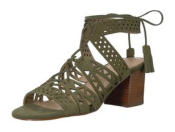

In [26]:
search_image_path = '16/16e48774.jpg'


base64encoded_jpeg_image = get_image_from_s3_as_base64(amazon_berkeley_bucket, search_image_path)
search_image = get_image_from_s3(amazon_berkeley_bucket, search_image_path)
plt.figure(figsize = (2,2))
plt.imshow(search_image)
plt.axis('off')
plt.show()

### Keyword Search

In [27]:
results = keyword_search(
    query_text=query_text
)

In [28]:
show_results_list(results)

--------------------------------------------------------------------------------------------------------------------------------
Score: 8.4351 	 Item ID: B01MYDNG7C
Item Name: Amazon Brand - The Fix Women's Cantu Ruffle Ankle Wrap Dress Sandal, Petal Blush, 9.5 B US
Fabric Type: Leather	 Material: None 	 Color: Petal Blush	 Style: Cantu Ruffle Ankle Wrap Sandal
--------------------------------------------------------------------------------------------------------------------------------
Score: 8.4351 	 Item ID: B06XH8M37Q
Item Name: Amazon Brand - The Fix Women's Farah Single Buckle Platform Dress Sandal, Petal Blush, 6.5 B US
Fabric Type: 100% Leather	 Material: None 	 Color: Petal Blush	 Style: Farah Single Buckle Platform Sandal
--------------------------------------------------------------------------------------------------------------------------------
Score: 8.4351 	 Item ID: B01MSCV2YB
Item Name: Amazon Brand - The Fix Women's Conley Lucite Heel Dress Sandal,Petal Blush,7.5 B 

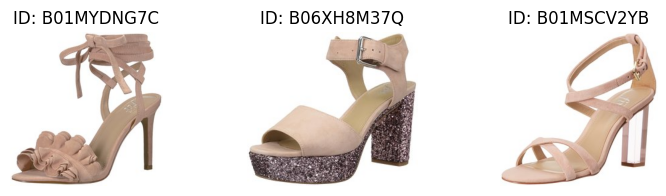

In [29]:
show_image_results(amazon_berkeley_bucket, results)

Keyword search using only text as input located `leather sandals` in the color `Petal Blush`, but it didn’t take the desired style into consideration. This happened because the query string alone does not capture enough features from the user intent to locate the correct style.

### Semantic Search using text and image as input

In [30]:
results = semantic_search(
    query_text=query_text, 
    query_jpg_image=base64encoded_jpeg_image
)

In [31]:
show_results_list(results)

--------------------------------------------------------------------------------------------------------------------------------
Score: 0.7072 	 Item ID: B01MZF96N7
Item Name: Amazon Brand - The Fix Women's Bonilla Block Heel Cutout Tribal Dress Sandal, Havana Tan, 7 B US
Fabric Type: Leather	 Material: Suede 	 Color: Havana Tan	 Style: Bonilla Block Heel Cutout Tribal Sandal
--------------------------------------------------------------------------------------------------------------------------------
Score: 0.7018 	 Item ID: B01MUG3C0Q
Item Name: Amazon Brand - The Fix Women's Farrell Triangle-Cutout Square Toe Flat Dress Sandal, Light Rose/Gold, 7.5 B US
Fabric Type: Synthetic	 Material: Leather 	 Color: Light Rose/Gold	 Style: Farrell Cutout Tribal Square Toe Flat Sandal
--------------------------------------------------------------------------------------------------------------------------------
Score: 0.6858 	 Item ID: B01MYDNG7C
Item Name: Amazon Brand - The Fix Women's Cantu R

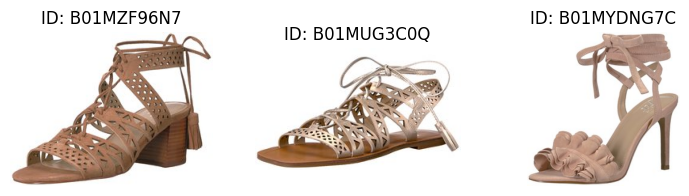

In [32]:
show_image_results(amazon_berkeley_bucket, results)

Semantic search using text and image as input located leather sandals and matched the desired style. However, the similarity to the provided images took priority over the specific color provided in `query_text`. In this case, the search returned leather sandals with straps but missed prioritizing the color `Petal Blush`. Also, the second result `B01MUG3C0Q` color is describbed as `Light Rose/Gold` which approximates but doesn't exactly match the desired color.

### Hybrid Search using only text as input

In [33]:
results = hybrid_search(
    query_text=query_text
)

In [34]:
show_results_list(results)

--------------------------------------------------------------------------------------------------------------------------------
Score: 1.0 	 Item ID: B01MYDNG7C
Item Name: Amazon Brand - The Fix Women's Cantu Ruffle Ankle Wrap Dress Sandal, Petal Blush, 9.5 B US
Fabric Type: Leather	 Material: None 	 Color: Petal Blush	 Style: Cantu Ruffle Ankle Wrap Sandal
--------------------------------------------------------------------------------------------------------------------------------
Score: 0.5384 	 Item ID: B075QDPVMX
Item Name: Truth & Fable Women's 124058 Ankle Strap Sandals, Grey, 8 US
Fabric Type: None	 Material: None 	 Color: Grey	 Style: 124058
--------------------------------------------------------------------------------------------------------------------------------
Score: 0.4657 	 Item ID: B07L5YGFFT
Item Name: Amazon Brand - find. Women's Woven Open Back Leather, Pink, US 8.5
Fabric Type: None	 Material: Leather 	 Color: Pink	 Style: Woven Open Back Leather
-------------

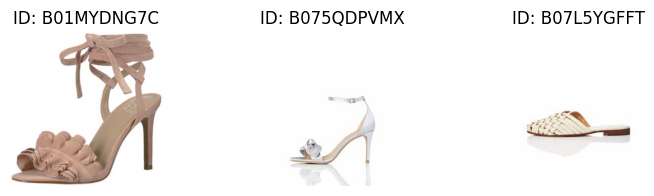

In [35]:
show_image_results(amazon_berkeley_bucket, results)

Hybrid search using only text as input located sandals with features that approximate to the embeddings of `query_text`. Only the top result is satisfactory, displaying `leather sandals in Petal Blush`.

### Hybrid Search using only image as input

In [36]:
results = hybrid_search(
    query_text="", 
    query_jpg_image=base64encoded_jpeg_image
)

In [37]:
show_results_list(results)

--------------------------------------------------------------------------------------------------------------------------------
Score: 0.6 	 Item ID: B01MZF96N7
Item Name: Amazon Brand - The Fix Women's Bonilla Block Heel Cutout Tribal Dress Sandal, Havana Tan, 7 B US
Fabric Type: Leather	 Material: Suede 	 Color: Havana Tan	 Style: Bonilla Block Heel Cutout Tribal Sandal
--------------------------------------------------------------------------------------------------------------------------------
Score: 0.4252 	 Item ID: B01MZF931K
Item Name: Amazon Brand - The Fix Women's Bonilla Block Heel Cutout Tribal Dress Sandal, Black, 6 B US
Fabric Type: Leather	 Material: None 	 Color: Black	 Style: Bonilla Block Heel Cutout Tribal Sandal
--------------------------------------------------------------------------------------------------------------------------------
Score: 0.2211 	 Item ID: B01MTEI3IP
Item Name: Amazon Brand - The Fix Women's Page Block Heel Ghillie Dress Sandal
Fabric Type:

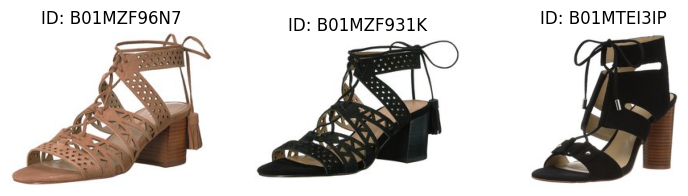

In [38]:
show_image_results(amazon_berkeley_bucket, results)

Hybrid search using only image as input located sandals with features that approximate to the embeddings of `query_jpg_image`. The styles of the sandals match the query image well, but the search missed on the desired color `Petal Blush`.

### Hybrid Search using text and image as input

In [39]:
results = hybrid_search(
    query_text=query_text,
    query_jpg_image=base64encoded_jpeg_image
)

In [40]:
show_results_list(results)

--------------------------------------------------------------------------------------------------------------------------------
Score: 0.6838 	 Item ID: B01MYDNG7C
Item Name: Amazon Brand - The Fix Women's Cantu Ruffle Ankle Wrap Dress Sandal, Petal Blush, 9.5 B US
Fabric Type: Leather	 Material: None 	 Color: Petal Blush	 Style: Cantu Ruffle Ankle Wrap Sandal
--------------------------------------------------------------------------------------------------------------------------------
Score: 0.6 	 Item ID: B01MZF96N7
Item Name: Amazon Brand - The Fix Women's Bonilla Block Heel Cutout Tribal Dress Sandal, Havana Tan, 7 B US
Fabric Type: Leather	 Material: Suede 	 Color: Havana Tan	 Style: Bonilla Block Heel Cutout Tribal Sandal
--------------------------------------------------------------------------------------------------------------------------------
Score: 0.5198 	 Item ID: B01MUG3C0Q
Item Name: Amazon Brand - The Fix Women's Farrell Triangle-Cutout Square Toe Flat Dress Sandal,

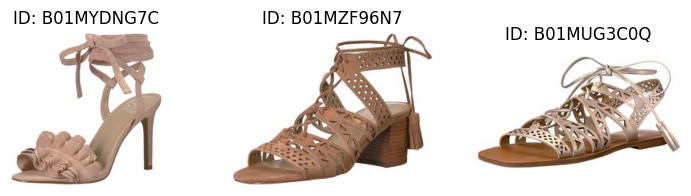

In [41]:
show_image_results(amazon_berkeley_bucket, results)

Hybrid search using text and image returned similar results to the semantic search using text and image because they use the same embeddings model. However, by combining the output of keyword and semantic searches, the ranking of the `Petal Blush` sandal that most closely matches `query_jpg_image` increases, moving `B01MYDNG7C` the top of the results list.

# Cleanup

After you complete this walkthrough, clean up all the resources you created as part of this post. This is an important step to make sure you don’t incur any unexpected charges.

If you used the provided CloudFormation template to create an OpenSearch Service domain specifically for this exercise, you can delete the stack following the guide [Delete a stack from the CloudFormation console](https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/cfn-console-delete-stack.html).

If you used an existing OpenSearch Service domain, you can run the following requests to cleanup your domain: delete the index, undeploy the model, delete the model, delete the model group, and delete the Amazon Bedrock connector.

In [42]:
# Delete Index OpenSearch service domain.
# https://opensearch.org/docs/latest/api-reference/index-apis/delete-index/
response = requests.delete(
    url=f"{OPENSEARCH_ENDPOINT}/{OPENSEARCH_INDEX_NAME}",
    headers={"Content-Type": "application/json"},
    auth=open_search_auth
)

In [43]:
# Undeploy the model in OpenSearch service domain.
# https://opensearch.org/docs/latest/ml-commons-plugin/api/model-apis/undeploy-model/
response = requests.post(
    url=f"{OPENSEARCH_ENDPOINT}/_plugins/_ml/models/{model_id}/_undeploy",
    headers={"Content-Type": "application/json"},
    auth=open_search_auth
)

# Delete the model in OpenSearch service domain.
# https://opensearch.org/docs/latest/ml-commons-plugin/api/model-apis/delete-model/
response = requests.delete(
    url=f"{OPENSEARCH_ENDPOINT}/_plugins/_ml/models/{model_id}",
    headers={"Content-Type": "application/json"},
    auth=open_search_auth
)

# Delete the model group in OpenSearch service domain.
# https://opensearch.org/docs/latest/ml-commons-plugin/api/model-group-apis/delete-model-group/
response = requests.delete(
    url=f"{OPENSEARCH_ENDPOINT}/_plugins/_ml/model_groups/{model_group_id}",
    headers={"Content-Type": "application/json"},
    auth=open_search_auth
)

# Delete the Amazon Bedrock connector in OpenSearch service domain.
# https://opensearch.org/docs/latest/ml-commons-plugin/api/connector-apis/delete-connector/
response = requests.delete(
    url=f"{OPENSEARCH_ENDPOINT}/_plugins/_ml/connectors/{connector_id}",
    headers={"Content-Type": "application/json"},
    auth=open_search_auth
)